### "The Influence of Foreign Direct Investment on Technological Advancements in Emerging Economies"
#### Author - Tarick Akpan

### PRELIMINARY THOUGHTS:

- The hypothesis, prior to analysing any data, is that foreign direct investment positively influences technological advancements in emerging economies. An increase in FDI will increase R&D, HTE and Patent applications, all else being held constant. 

- Null Hypothesis  H0: Foreign direct investment has no impact on technological advancement in emerging economies.
- Alternative Hypothesis  HA: Foreign direct investment has a statistically significant impact on technological advancement in emerging economies.

### STANDARD IMPORTS:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
from linearmodels.panel import compare
import warnings
from scipy.stats import chi2
from linearmodels import PanelOLS, RandomEffects

In [2]:
#pip install RISE

### IMPORT DATASETS:

In [3]:
FDI = pd.read_csv('https://raw.githubusercontent.com/tarick-akpan/EC2402-PROJECT/main/FDI%20DATA%20WB.csv')

In [4]:
RD = pd.read_csv('https://raw.githubusercontent.com/tarick-akpan/EC2402-PROJECT/main/R%26D%20expenditure%20WB.csv')

In [5]:
Patent = pd.read_csv('https://raw.githubusercontent.com/tarick-akpan/EC2402-PROJECT/main/Patent%20Data%20WB.csv')

In [6]:
HTE = pd.read_csv('https://raw.githubusercontent.com/tarick-akpan/EC2402-PROJECT/main/High%20Tech%20Exports.csv')

In [7]:
Pop = pd.read_csv('https://raw.githubusercontent.com/tarick-akpan/EC2402-PROJECT/main/Population%20Data%20WB.csv')

### CLEAN THE DATA:

In [8]:
# Melt each dataset to have years as rows instead of columns
fdi_melted = FDI.melt(id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], var_name='Year', value_name='FDI')
rd_melted = RD.melt(id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], var_name='Year', value_name='RD')
patent_melted = Patent.melt(id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], var_name='Year', value_name='Patent')
hte_melted = HTE.melt(id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], var_name='Year', value_name='HTE')
Pop_melted = Pop.melt(id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], var_name='Year', value_name='Population')


In [9]:
# Drop unnecessary columns
fdi_melted = fdi_melted.drop(['Indicator Name', 'Indicator Code'], axis=1)
rd_melted = rd_melted.drop(['Indicator Name', 'Indicator Code'], axis=1)
patent_melted = patent_melted.drop(['Indicator Name', 'Indicator Code'], axis=1)
hte_melted = hte_melted.drop(['Indicator Name', 'Indicator Code'], axis=1)
Pop_melted = Pop_melted.drop(['Indicator Name', 'Indicator Code'], axis=1)

In [10]:
# Merge all datasets together
Tech = fdi_melted.merge(rd_melted, on=['Country Name', 'Country Code', 'Year'], how='outer') \
                     .merge(patent_melted, on=['Country Name', 'Country Code', 'Year'], how='outer') \
                      .merge(Pop_melted, on=['Country Name', 'Country Code', 'Year'], how='outer') \
                      .merge(hte_melted, on=['Country Name', 'Country Code', 'Year'], how='outer')


In [11]:
# Create array of 'Emerging Economies'
countries = ['Brazil', 'China', 'India', 'Indonesia', 'Mexico', 'Russia', 'South Africa', 'Turkey', 'Argentina', 'Colombia', 'Egypt', 'Iran', 'Malaysia', 'Nigeria', 'Pakistan', 'Philippines', 'Thailand', 'Vietnam', 'Bangladesh', 'Ukraine']

# Filter the dataframe for these economies
Tech = Tech[Tech['Country Name'].isin(countries)]

In [12]:
# Drop 'Unnamed: 66'
Tech = Tech[Tech['Year'] != 'Unnamed: 66']

In [13]:
# Drop rows where FDI, RD, Patent, HTE all are NaN
Tech = Tech.copy()
Tech.dropna(subset=['FDI', 'RD', 'Patent', 'HTE'], how='all', inplace=True)

In [14]:
# Convert Year column to only be integers 
Tech['Year'] = Tech['Year'].astype(int)

# Keep only values from 2001 - 2021 (20 year period)
Tech = Tech[Tech['Year'] >= 2001]

In [15]:
# Reset the index
Tech = Tech.reset_index(drop=True)

In [16]:
Tech

,Country Name,Country Code,Year,FDI,RD,Patent,Population,HTE
0,Argentina,ARG,2001,2.166137e+09,0.42461,691.0,3.748049e+07,NaN
1,Bangladesh,BGD,2001,7.852704e+07,NaN,59.0,1.316705e+08,NaN
2,Brazil,BRA,2001,2.322585e+10,1.06198,3439.0,1.782119e+08,NaN
3,China,CHN,2001,4.705300e+10,0.94033,30038.0,1.271850e+09,NaN
4,Colombia,COL,2001,2.541943e+09,0.13290,65.0,3.983788e+07,NaN
...,...,...,...,...,...,...,...,...
331,Philippines,PHL,2021,1.241263e+10,NaN,NaN,1.138803e+08,64.225253
332,Thailand,THA,2021,1.464087e+10,NaN,NaN,7.160110e+07,NaN
333,Ukraine,UKR,2021,7.954000e+09,NaN,NaN,4.379286e+07,4.510374
334,Vietnam,VNM,2021,1.566000e+10,NaN,NaN,9.746803e+07,NaN


### EXPLANATORY DATA ANALYSIS:

As the first part of our explanatory analysis, it would be useful to identify the distribution of FDI between the countries in our datasets. Whilst some countries receive more FDI, they are have a larger share of the global population.

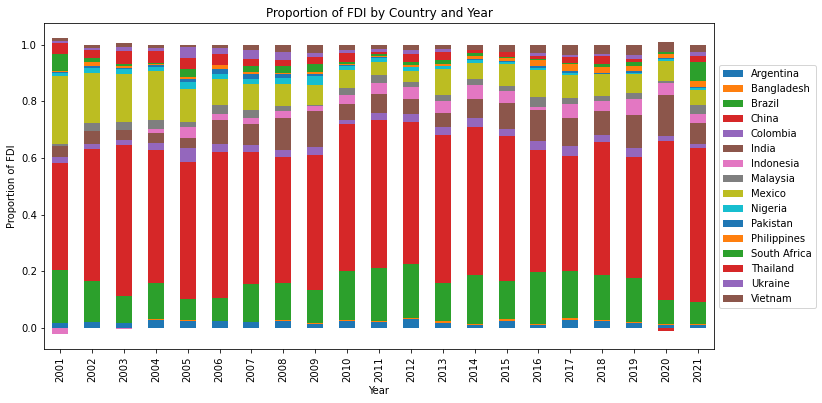

In [17]:
# Determine which countries make up the greatest proportion of FDI:

# Group by year and sum the FDI by country
grouped = Tech.groupby(['Year', 'Country Name'])['FDI'].sum().unstack()

# Normalize the data to get the proportion
normalized = grouped.div(grouped.sum(axis=1), axis=0)

# Create a stacked bar chart
normalized.plot(kind='bar', stacked=True, figsize=(12,6))

# Add title and labels
plt.title('Proportion of FDI by Country and Year')
plt.xlabel('Year')
plt.ylabel('Proportion of FDI')

# move the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()

From the stacked bar chart above, we can infer that only a handful of countries make up around 80% of FDI from our current dataset. These are China, South Africa, Pakistan, Colombia, India, Malaysia and Mexico. In addition to this, it is fair to conclude that this distribution remained quite constant for the entire 20 year period, with, in recent years, more countries receiving additional investment. 

Prior to undertaking statistical analysis, it is important to see the degree of FDI on a per capita basis. In other words, do countries which receive a high level of foreign direct investment, and subsequently apply for more patents, produce more high tech exports and conduct more research and development only do so as they have a larger population, or do so as a result of the high level of FDI. This can be shown in the figure below:

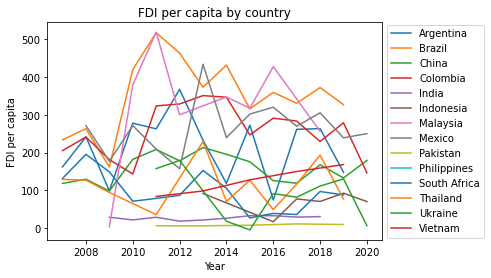

In [18]:
# Create a new DataFrame with per capita values
Tech_per_capita = Tech.copy()

# Per-capita inclusions:
Tech_per_capita['FDI per capita'] = Tech['FDI'] / Tech['Population']
Tech_per_capita['RD per capita'] = Tech['RD'] / Tech['Population']
Tech_per_capita['Patent per capita'] = Tech['Patent'] / Tech['Population']
Tech_per_capita['HTE per capita'] = Tech['HTE'] / Tech['Population']

# Drop the original columns
Tech_per_capita = Tech_per_capita.drop(['FDI', 'RD', 'Patent', 'HTE'], axis=1)

# Drop rows with NaN values in the year-to-year changes columns
Tech_per_capita = Tech_per_capita.dropna(subset=['FDI per capita', 'RD per capita', 'Patent per capita', 'HTE per capita'], how='all')

# Drop rows with any NaN values
Tech_per_capita = Tech_per_capita.dropna()

# Reset the index
Tech_per_capita = Tech_per_capita.reset_index(drop=True)

# Group the DataFrame by Country Name
Tech_per_capita_grouped = Tech_per_capita.groupby('Country Name')

# Plot the FDI per capita for each country
for name, group in Tech_per_capita_grouped:
    plt.plot(group['Year'], group['FDI per capita'], label=name)

# Set the axis labels and title
plt.xlabel('Year')
plt.ylabel('FDI per capita')
plt.title('FDI per capita by country')

# Show the legend
plt.legend()

# Move the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


# Show the plot
plt.show()


As we can see from the figure above, countries such as Brazil, Mexico, Malaysia and Colombia make up the largest share of FDI per capita. This contrasts the prior figure, identifying that China, South Africa, Pakistan and India were among the countries which received the greatest share of FDI. This is important for further analysis as increases in our X-variables (Patent, HTE and RD) may not be caused by increases in our Y-variable (FDI) but instead, our Y-variable increases/decreases due to the external population effect, which subsequently causes our X-variables to change. This would be a factor we will consider and explore during statistical analysis.

Now that we have determined that some countries share of FDI is distroted, we can begin adjusting our data to identify linearity. We can begin by wishing to identify whether a relationship exists between our explanatory and independent variables. This can be shown in a scatterplot, as done so below:

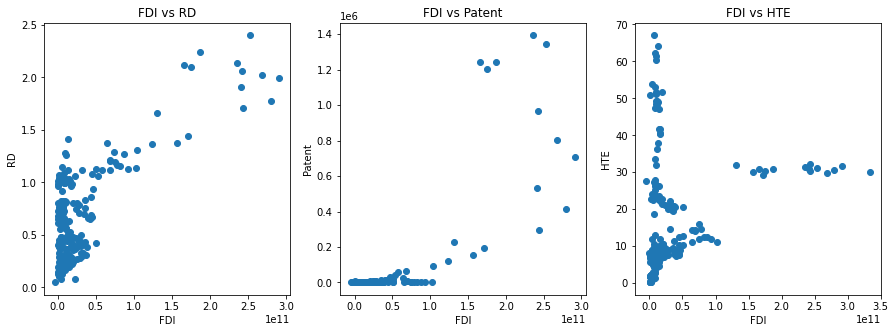

In [19]:
# Visualise the data with scatterplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# FDI vs RD
axs[0].scatter(Tech['FDI'], Tech['RD'])
axs[0].set_xlabel('FDI')
axs[0].set_ylabel('RD')
axs[0].set_title('FDI vs RD')

# FDI vs Patent 
axs[1].scatter(Tech['FDI'], Tech['Patent'])
axs[1].set_xlabel('FDI')
axs[1].set_ylabel('Patent')
axs[1].set_title('FDI vs Patent')

# FDI vs HTE
axs[2].scatter(Tech['FDI'], Tech['HTE'])
axs[2].set_xlabel('FDI')
axs[2].set_ylabel('HTE')
axs[2].set_title('FDI vs HTE')

plt.show()


As we can see in the three plots above, a somewhat positive relatiobship exists between each of our 3 indicators and FDI. Perhaps most obviously, there is quite a strong positive relationship between foreign direct investment and research and development. We would therefore expect that FDI strongly promotes R&D in emerging economies. Secondly, there seems to be a slightly more tenuous, but positive, relationship between FDI and Patent applications. When FDI is high, so are Patent Applications. Lastly, our third plot illustrates that FDI is not strongly correlated with HTE, or, simply there are a large degree of outliers which skew the metrics of the x-axis. This will require further research.

In [20]:
# Create a correlation matrix to identify the degree of correlation:
Tech[['FDI', 'RD', 'Patent', 'HTE']].corr()

,FDI,RD,Patent,HTE
FDI,1.000000,0.772262,0.792065,0.247887
RD,0.772262,1.000000,0.686256,0.457678
Patent,0.792065,0.686256,1.000000,0.228441
HTE,0.247887,0.457678,0.228441,1.000000


The correlation matrix above illustrates our previous assertions. There is a strong correlation between FDI and R&D, with a correlation coefficient of 0.77. The same can be said for the relationship between FDI and Patent applications, with an even stronger correlation coefficient of 0.79. As previously mentioned, however, the relationship between HTE and FDI is likely skewed due to outliers. This results in a correlation coefficient of 0.25.

As we can see however, we have an issue if non-linearity. In order to better aid statistical analysis, we can include in our data per-capita values and then check for linearity. We can do this with our previous created 'Tech_per_capita' dataframe:

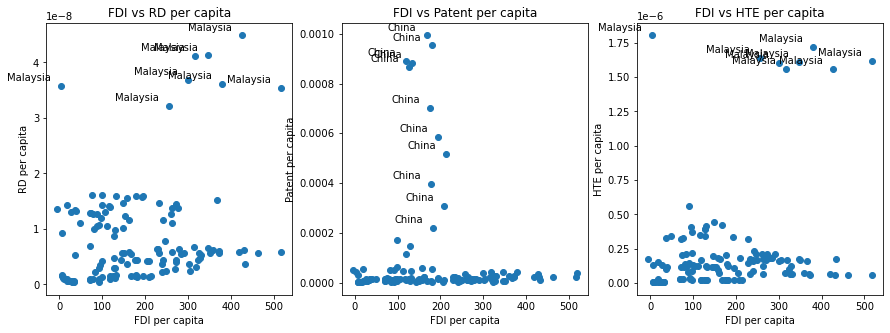

In [21]:
# Check for linearity again with per capita values:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

### RD
# Define the threshold for outliers
RD_outlier_threshold = 2 * 1e-8

# FDI vs RD per capita
axs[0].scatter(Tech_per_capita['FDI per capita'], Tech_per_capita['RD per capita'])
axs[0].set_xlabel('FDI per capita')
axs[0].set_ylabel('RD per capita')
axs[0].set_title('FDI vs RD per capita')

# Iterate through the data points and label the outliers
for index, row in Tech_per_capita.iterrows():
    fdi_per_capita = row['FDI per capita']
    rd_per_capita = row['RD per capita']
    country_name = row['Country Name']

    if rd_per_capita > RD_outlier_threshold:
        axs[0].annotate(country_name, (fdi_per_capita, rd_per_capita), textcoords="offset points", xytext=(-10, 5), ha='right')

### PATENT
# Define the threshold for outliers
patent_outlier_threshold = 0.0002
        
# FDI vs Patent 
axs[1].scatter(Tech_per_capita['FDI per capita'], Tech_per_capita['Patent per capita'])
axs[1].set_xlabel('FDI per capita')
axs[1].set_ylabel('Patent per capita')
axs[1].set_title('FDI vs Patent per capita')

# Iterate through the data points and label the outliers
for index, row in Tech_per_capita.iterrows():
    fdi_per_capita = row['FDI per capita']
    patent_per_capita = row['Patent per capita']
    country_name = row['Country Name']

    if patent_per_capita > patent_outlier_threshold:
        axs[1].annotate(country_name, (fdi_per_capita, patent_per_capita), textcoords="offset points", xytext=(-10, 5), ha='right')

### HTE
# Define the threshold for outliers
hte_outlier_threshold = 0.75 *1e-6

# FDI vs HTE
axs[2].scatter(Tech_per_capita['FDI per capita'], Tech_per_capita['HTE per capita'])
axs[2].set_xlabel('FDI per capita')
axs[2].set_ylabel('HTE per capita')
axs[2].set_title('FDI vs HTE per capita')

# Iterate through the data points and label the outliers
for index, row in Tech_per_capita.iterrows():
    fdi_per_capita = row['FDI per capita']
    hte_per_capita = row['HTE per capita']
    country_name = row['Country Name']

    if hte_per_capita > hte_outlier_threshold:
        axs[2].annotate(country_name, (fdi_per_capita, hte_per_capita), textcoords="offset points", xytext=(-10, 5), ha='right')

plt.show()    

As we can see from the output above, changing the data to have per capita values did not provide us with a linear relationship. We can see that observations from both Malaysia and China bias our results drastically through large outliers. We can remove these observations during subsequent analysis to determine the effect of these countries. At this cuurent time we can reproduce our scatterplot in an attempt to observe a linear trend.

In [22]:
# Drop outliers from Tech per capita dataset
# Find the index values for Malaysia and China
malaysia_index = Tech_per_capita[Tech_per_capita['Country Name'] == 'Malaysia'].index
china_index = Tech_per_capita[Tech_per_capita['Country Name'] == 'China'].index

# Drop the rows corresponding to Malaysia and China
Tech_per_capita= Tech_per_capita.drop(malaysia_index)
Tech_per_capita = Tech_per_capita.drop(china_index)

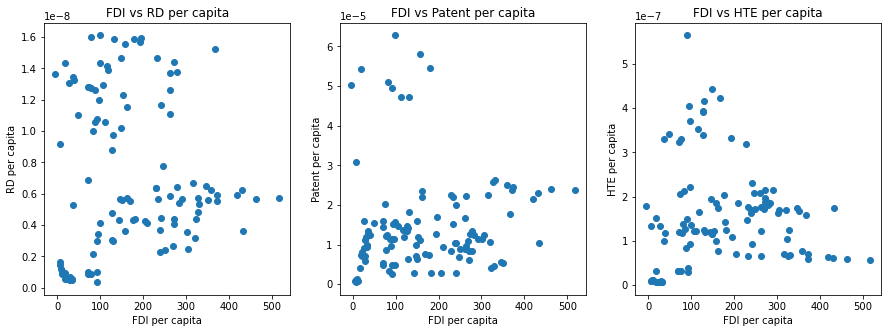

In [23]:
# Check for linearity again with new per capita values:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# FDI vs RD per capita
axs[0].scatter(Tech_per_capita['FDI per capita'], Tech_per_capita['RD per capita'])
axs[0].set_xlabel('FDI per capita')
axs[0].set_ylabel('RD per capita')
axs[0].set_title('FDI vs RD per capita')

# FDI vs Patent 
axs[1].scatter(Tech_per_capita['FDI per capita'], Tech_per_capita['Patent per capita'])
axs[1].set_xlabel('FDI per capita')
axs[1].set_ylabel('Patent per capita')
axs[1].set_title('FDI vs Patent per capita')

# FDI vs HTE
axs[2].scatter(Tech_per_capita['FDI per capita'], Tech_per_capita['HTE per capita'])
axs[2].set_xlabel('FDI per capita')
axs[2].set_ylabel('HTE per capita')
axs[2].set_title('FDI vs HTE per capita')

plt.show()

As we can see, our scatterplots now indicate that a linear trend exists between our y-variables and our x-variable. However, as we can see, this trend is not incredibly strong.

Instead, we can use year-to-year changes to attempt to find a linear trend. If this does not produce a linear trend, we can transform our data (i.e. into log form) or use an alternative model when we begin statistical analysis. 

In [24]:
# Create a new DataFrame to store the year-to-year changes
Tech_changes = Tech.copy()

# Calculate the year-to-year changes for FDI, RD, Patent, and HTE
Tech_changes['FDI change'] = Tech_changes.groupby(['Country Name'])['FDI'].diff()
Tech_changes['RD change'] = Tech_changes.groupby(['Country Name'])['RD'].diff()
Tech_changes['Patent change'] = Tech_changes.groupby(['Country Name'])['Patent'].diff()
Tech_changes['HTE change'] = Tech_changes.groupby(['Country Name'])['HTE'].diff()

# Drop the original columns
Tech_changes = Tech_changes.drop(['FDI', 'RD', 'Patent', 'HTE'], axis=1)

# Drop rows with NaN values in the year-to-year changes columns
Tech_changes = Tech_changes.dropna(subset=['FDI change', 'RD change', 'Patent change', 'HTE change'], how='all')

# Drop rows with any NaN values
Tech_changes = Tech_changes.dropna()

# Reset the index
Tech_changes = Tech_changes.reset_index(drop=True)

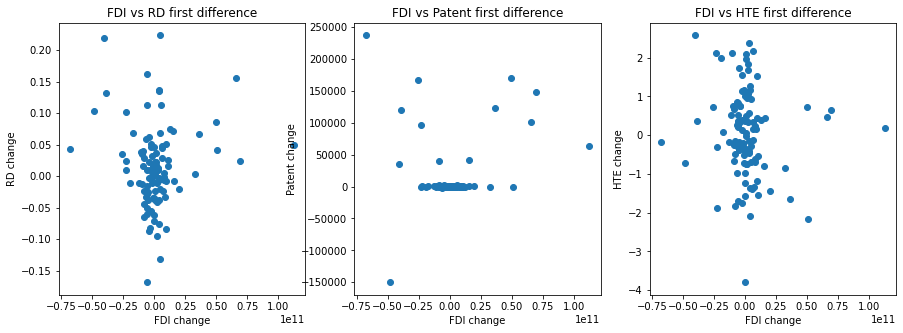

In [25]:
# Check for linearity again with per first differenced values:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# FDI vs RD per capita
axs[0].scatter(Tech_changes['FDI change'], Tech_changes['RD change'])
axs[0].set_xlabel('FDI change')
axs[0].set_ylabel('RD change')
axs[0].set_title('FDI vs RD first difference')

# FDI vs Patent 
axs[1].scatter(Tech_changes['FDI change'], Tech_changes['Patent change'])
axs[1].set_xlabel('FDI change')
axs[1].set_ylabel('Patent change')
axs[1].set_title('FDI vs Patent first difference')

# FDI vs HTE
axs[2].scatter(Tech_changes['FDI change'], Tech_changes['HTE change'])
axs[2].set_xlabel('FDI change')
axs[2].set_ylabel('HTE change')
axs[2].set_title('FDI vs HTE first difference')

plt.show()

As we can see from the plots above, our data appears to be slightly more linear. However, a linear model is still perhaps not most appropriate. Instead, we will log transform some of our data.

In [26]:
# Create a new DataFrame to store the transformed values
Tech_transformed = Tech.copy()

# Add a small constant to the column values to avoid negative or zero values
# Apply the logarithmic transformation to FDI, RD, Patent, and HTE
Tech_transformed['Log FDI'] = np.log(Tech['FDI'] + 1)
Tech_transformed['Log RD'] = np.log(Tech['RD'] + 1)
Tech_transformed['Log Patent'] = np.log(Tech['Patent'] + 1)
Tech_transformed['Log HTE'] = np.log(Tech['HTE'] + 1)

# Drop the original columns
Tech_transformed = Tech_transformed.drop(['FDI', 'RD', 'Patent', 'HTE'], axis=1)

# Drop rows with NaN or negative values
Tech_transformed = Tech_transformed.dropna()

/Users/user/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


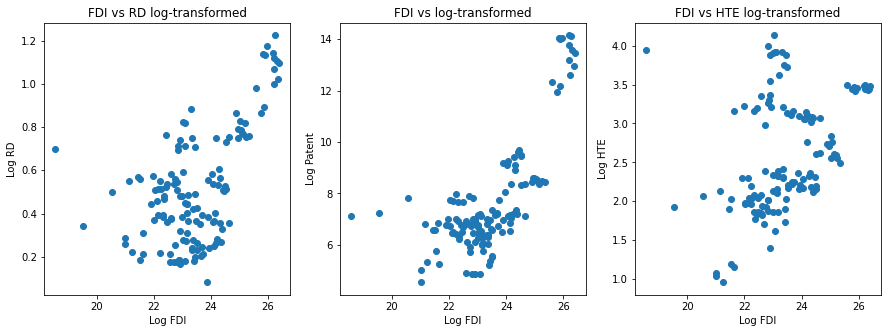

In [27]:
# Check for linearity again with log-transformed values:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# FDI vs RD per capita
axs[0].scatter(Tech_transformed['Log FDI'], Tech_transformed['Log RD'])
axs[0].set_xlabel('Log FDI')
axs[0].set_ylabel('Log RD')
axs[0].set_title('FDI vs RD log-transformed')

# FDI vs Patent 
axs[1].scatter(Tech_transformed['Log FDI'], Tech_transformed['Log Patent'])
axs[1].set_xlabel('Log FDI')
axs[1].set_ylabel('Log Patent')
axs[1].set_title('FDI vs log-transformed')

# FDI vs HTE
axs[2].scatter(Tech_transformed['Log FDI'], Tech_transformed['Log HTE'])
axs[2].set_xlabel('Log FDI')
axs[2].set_ylabel('Log HTE')
axs[2].set_title('FDI vs HTE log-transformed')

plt.show()

As we can see above, we now have some nice, linear data. We will use these log transformations to create and build statistical models.

In [28]:
# Add log transformed values to our dataframe 'Tech'
# Apply the logarithmic transformation to FDI, RD, Patent, and HTE
Tech['Log FDI'] = np.log(Tech['FDI'] + 1)
Tech['Log RD'] = np.log(Tech['RD'] + 1)
Tech['Log Patent'] = np.log(Tech['Patent'] + 1)
Tech['Log HTE'] = np.log(Tech['HTE'] + 1)

# RE-ORDER DATAFRAME FOR ASTHETICS
# Specify the desired order of columns
new_order = [
    'Country Name', 'Country Code', 'Year', 'Population',
    'FDI', 'Log FDI',
    'RD', 'Log RD',
    'Patent', 'Log Patent',
    'HTE', 'Log HTE'
]

# Reorder the DataFrame columns using the new_order list
Tech = Tech[new_order]

# Drop rows with NaN or negative values
Tech= Tech.dropna()

# Reset the index
Tech = Tech.reset_index(drop=True)

/Users/user/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### PRELIMINARYS PRIOR TO STATISTICAL DATA ANALYSIS:

In [29]:
# Set index as Country Code and Year
Tech = Tech.set_index(['Country Code', 'Year'])

In [30]:
# Check for remaining NaN values
print(Tech.isna().sum())

Country Name    0
Population      0
FDI             0
Log FDI         0
RD              0
Log RD          0
Patent          0
Log Patent      0
HTE             0
Log HTE         0
dtype: int64


### STATISTICAL DATA ANALYSIS:

- Given that we have panel data (i.e., data with both cross-sectional and time-series dimensions), a suitable model to analyze the effect of FDI on HTE, RD, and Patent would be a fixed effects or random effects model, depending on our assumptions about the unobserved factors. 
- Since we believe that unobserved factors, such as population, are not random, we can predict that a fixed-effects model would be most suitable. 
- The rationale behind this choice is that country-specific factors, such as political stability, regulatory environment, and institutional quality, can have an impact on both FDI inflows and technological advancements. These country-specific factors may be correlated with the regressors in our model.

* It should also be mentioned that we add a constant to both of the models below since there is no meaningful 0 point, in addition to the presence of underlying effects which are not account for in our model.

### FIXED EFFECTS

In [31]:
# Create our model
# Add a constant to the independent variable (FDI)
X = Tech[['Log FDI']]
X = sm.add_constant(X)

# Run separate regressions for each dependent variable
dependent_vars = ['Log Patent', 'Log HTE', 'Log RD']

for var in dependent_vars:
    y = Tech[var]
    fixed_effects_model = PanelOLS(y, X, entity_effects=True)
    fixed_effects_results = fixed_effects_model.fit()
    
    print(f"Results for {var} as the dependent variable:")
    print(fixed_effects_results)
    print("\n")


Results for Log Patent as the dependent variable:
                          PanelOLS Estimation Summary                           
Dep. Variable:             Log Patent   R-squared:                        0.0282
Estimator:                   PanelOLS   R-squared (Between):              0.0808
No. Observations:                 135   R-squared (Within):               0.0282
Date:                Thu, Oct 19 2023   R-squared (Overall):              0.0959
Time:                        23:10:44   Log-likelihood                   -53.157
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      3.4884
Entities:                          14   P-value                           0.0642
Avg Obs:                       9.6429   Distribution:                   F(1,120)
Min Obs:                       1.0000                                           
Max Obs:                       14.000   F-statistic (robust

### Interpretation

##### Log Patent as the dependent variable:
The coefficient of Log FDI is positive (0.1060), which implies that as FDI increases, the number of patents (technological advancements) increases as well. However, the p-value is 0.0642, which is slightly greater than the conventional significance level of 0.05. This means that we cannot confidently conclude that there is a significant relationship between FDI and patents at a 95% confidence level. If we were to consider a 90% confidence level, the relationship would be significant. The R-squared value within (0.0282) indicates that the model explains about 2.82% of the variation in Log Patent within countries.

##### Log HTE as the dependent variable:
The coefficient of Log FDI is negative (-0.0041), but the p-value is 0.8536, indicating that the relationship is not statistically significant. This result suggests that there is no clear evidence to support the idea that FDI affects high-technology exports (HTE) in emerging economies. Given the high p-value and the R-squared value within (0.0003) being close to zero, it can be concluded that FDI may not be an important determinant of HTE. Policymakers should investigate other factors that could better explain the variation in high-technology exports.

##### Log RD as the dependent variable:
The coefficient of Log FDI is positive (0.0203), but the p-value is 0.1176, which is greater than the conventional significance level of 0.05. This finding implies that there is no statistically significant relationship between FDI and R&D expenditure at a 95% confidence level. The R-squared value within (0.0203) indicates that the model explains only 2.03% of the variation in Log RD within countries. In this context, FDI appears to be largely irrelevant in explaining R&D expenditure. Policymakers should explore other determinants of R&D expenditure to better understand its variation and devise effective policies to boost R&D activities.

##### Overall:
The Fixed Effects model suggests a positive and statistically significant relationship between FDI and patents at a 90% confidence level, indicating that FDI may contribute to patent activities in emerging economies. However, the relationships between FDI and high-technology exports and FDI and R&D expenditure are not statistically significant. Based on these results, FDI alone may not be a significant determinant of technological advancements in emerging economies, and policymakers should consider other factors that could better explain the variation in high-technology exports and R&D expenditure.

### RANDOM EFFECTS
However, there also exists an argument for modeling our data using a random effects model. Under the assumption that the unobserved individual heterogeneity (i.e., the differences between the emerging economies in your sample) does not affect the relationship between Foreign Direct Investment (FDI) and technological advancements, a random effects models can be more efficient than fixed effects models as they take into account both within-entity (i.e., time-series) and between-entity (i.e., cross-sectional) variations in the data.

In [32]:
# Add a constant to the independent variable (Log FDI)
X = Tech[['Log FDI']]
X = sm.add_constant(X)

# Run separate regressions for each dependent variable
dependent_vars = ['Log Patent', 'Log HTE', 'Log RD']

for var in dependent_vars:
    y = Tech[var]
    
    # Estimate the Random Effects model
    random_effects_model = RandomEffects(y, X)
    random_effects_results = random_effects_model.fit()
    
    print(f"Results for {var} as the dependent variable:")
    print(random_effects_results)
    print("\n")
      
    # Add the fitted values column to the Tech dataframe
    Tech[f'fitted {var}'] = random_effects_results.predict(X)


Results for Log Patent as the dependent variable:
                        RandomEffects Estimation Summary                        
Dep. Variable:             Log Patent   R-squared:                        0.0830
Estimator:              RandomEffects   R-squared (Between):              0.1426
No. Observations:                 135   R-squared (Within):               0.0228
Date:                Thu, Oct 19 2023   R-squared (Overall):              0.1213
Time:                        23:10:44   Log-likelihood                   -67.732
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      12.035
Entities:                          14   P-value                           0.0007
Avg Obs:                       9.6429   Distribution:                   F(1,133)
Min Obs:                       1.0000                                           
Max Obs:                       14.000   F-statistic (robust

### Interpretation

##### Log Patent as the dependent variable:
The coefficient of Log FDI is positive (0.1525) and statistically significant at a 95% confidence level (p-value: 0.0106 ). This result suggests that an increase in FDI is associated with an increase in patent activities, with a 1% increase in FDI leading to approximately a 0.1525% increase in patents. The R-squared (Overall) is 0.0830, indicating that about 8.3% of the variation in Log Patent can be explained by Log FDI. This finding supports the notion that FDI may contribute to technological advancements in emerging economies. However, policymakers should also consider other factors that contribute to technological advancements, as FDI alone may not be sufficient to drive significant innovation given the small R-squared value.

#### Log HTE as the dependent variable:
The coefficient of Log FDI is negative (-0.0004), but the p-value is 0.9861, indicating that the relationship is not statistically significant. This result suggests that there is no clear evidence to support the idea that FDI affects high-technology exports (HTE) in emerging economies. Given the insignificant relationship and the R-squared (Overall) being 0.0951, it can be concluded that FDI may not be an important determinant of HTE.

##### Log RD as the dependent variable:
The coefficient of Log FDI is positive (0.0275), and the p-value is 0.0304, which is below the conventional significance level of 0.05. This finding implies that there is a statistically significant relationship between FDI and R&D expenditure at a 95% confidence level. The R-squared (Overall) is 0.0091, indicating that the model explains only 0.91% of the variation in Log RD. In this context, FDI appears to very litttle relevance in explaining R&D expenditure.

##### Overall
The random effects model suggests a positive and statistically significant relationship between FDI and patents, indicating that FDI may contribute to patent activities in emerging economies. However, the relationship between FDI and high-technology exports is not statistically significant, and the relationship between FDI and R&D expenditure is only marginally significant. Based on these results, FDI alone may not be a major determinant of technological advancements in emerging economies, and policymakers should consider other factors that could better explain the variation in high-technology exports and R&D expenditure.

### DELAYED EFFECTS

We also want to consider the possibility of delayed effects. This means that the impact of FDI in a given year might not be observed immediately but could take effect in subsequent years. To account for this, we can include lagged variables in our model.

- Including lagged variables in our model can help us capture the temporal dependencies or time series patterns in the data we observe. In other words, it allows us to account for the fact that a variable's value in the current period may depend on its value in the previous period. By including lagged variables, we can also control for the effects of unobserved variables that are constant over time but might impact our dependent variables (HTE, Patent, R&D), which can improve the accuracy of our previous estimates. 

- Additionally, lagged variables can help us to test hypotheses about the direction and magnitude of the effect of past values of our independent variable FDI on our dependent variable.

In [33]:
## Create Random-Effects model with lag
# Create a one-year lag of Log FDI
Tech['Lag1 Log FDI'] = Tech.groupby(level=0)['Log FDI'].shift(1)

# Drop rows with missing values due to lag creation
Tech = Tech.dropna()

# Create model variables
X = Tech[['Log FDI', 'Lag1 Log FDI']]
X = sm.add_constant(X)

# Run separate regressions for each dependent variable
dependent_vars = ['Log Patent', 'Log HTE', 'Log RD']

for var in dependent_vars:
    y = Tech[var]
    
    # Estimate the Random Effects model
    random_effects_model = RandomEffects(y, X)
    random_effects_results = random_effects_model.fit()
    
    print(f"Results for delayed {var} as the dependent variable:")
    print(random_effects_results)
    print("\n")

Results for delayed Log Patent as the dependent variable:
                        RandomEffects Estimation Summary                        
Dep. Variable:             Log Patent   R-squared:                        0.1028
Estimator:              RandomEffects   R-squared (Between):              0.2735
No. Observations:                 121   R-squared (Within):               0.0510
Date:                Thu, Oct 19 2023   R-squared (Overall):              0.2508
Time:                        23:10:45   Log-likelihood                   -44.608
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      6.7612
Entities:                          14   P-value                           0.0017
Avg Obs:                       8.6429   Distribution:                   F(2,118)
Min Obs:                       0.0000                                           
Max Obs:                       13.000   F-statistic

### Interpretation

##### Log Patent as the dependent variable:
For Log Patent as the dependent variable, the R-squared value is 0.1028. This indicates that approximately 10.28% of the variation in Log Patent can be explained by the model. Only Log FDI and not Lag1 Log FDI are statistically significant with a p-value of less than 0.05. The positive coefficients suggest that an increase in FDI and its lagged value have positive effects on patent activity. This suggests that the previous values of FDI have no impact on the patent applications in the following period. Log Lag 1 FDI is statistically significant considering a 10% confidence level. This makes logical sense as entrepeuneurs would react to economic inflows by investing in technological advancements.

##### Log HTE as the dependent variable:
For Log HTE as the dependent variable, the R-squared value is 0.0441, suggesting that only 4.41% of the variation in Log HTE can be explained by the model. However, both Log FDI and Lag1 Log FDI are not statistically significant (p-values > 0.05), indicating that there is no significant relationship between FDI and HTE when considering delayed effects.

##### Log RD as the dependent variable:
For Log RD as the dependent variable, the R-squared value is 0.0334, indicating that only 3.34% of the variation in Log RD can be explained by the model. The coefficient for Log FDI is statistically significant (p-value < 0.05) and positive, suggesting that an increase in FDI has a positive effect on R&D activity. However, the coefficient for Lag1 Log FDI is not statistically significant (p-value > 0.05), implying that the lagged value of FDI does not have a significant impact on R&D activity.

##### Overall
In summary, the delayed effects model shows that FDI has a positive and significant effect on patent activity, while the impact on HTE is not significant. For R&D activity, the current FDI has a positive and significant impact, but the lagged FDI does not show a significant relationship.

### MODEL ANALYSIS: VISUALISATIONS AND ROBUSTNESS TESTS

Firstly, we will create a visual plot in order to check the assumptions of our linear regression model. A residual plot will show the difference between the predicted values and the actual values (i.e., the residuals) plotted against the predicted values.

##### Residual Plots

In [34]:
# Drop the 'Lag1 Log FDI' column
Tech = Tech.drop('Lag1 Log FDI', axis=1)

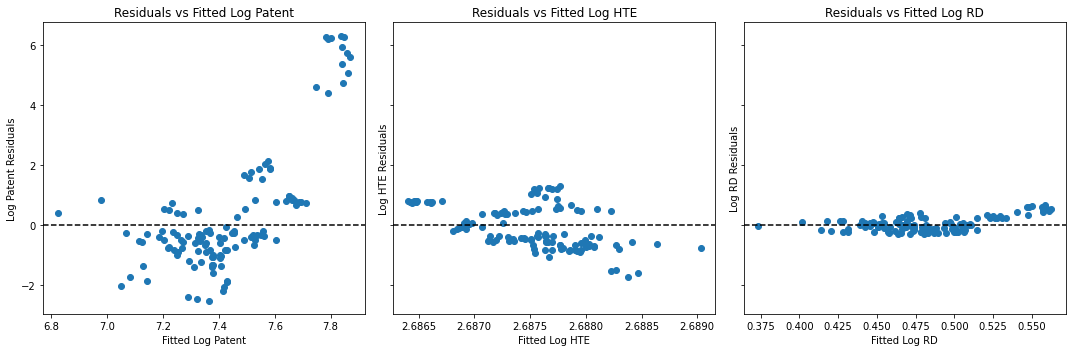

In [35]:
# Calculate residuals for each dependent variable
Tech['residual Log Patent'] = Tech['Log Patent'] - Tech['fitted Log Patent']
Tech['residual Log HTE'] = Tech['Log HTE'] - Tech['fitted Log HTE']
Tech['residual Log RD'] = Tech['Log RD'] - Tech['fitted Log RD']

# Plot residuals against fitted values for each dependent variable
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

axes[0].scatter(Tech['fitted Log Patent'], Tech['residual Log Patent'])
axes[0].axhline(y=0, color='k', linestyle='--')
axes[0].set_xlabel('Fitted Log Patent')
axes[0].set_ylabel('Log Patent Residuals')
axes[0].set_title('Residuals vs Fitted Log Patent')

axes[1].scatter(Tech['fitted Log HTE'], Tech['residual Log HTE'])
axes[1].axhline(y=0, color='k', linestyle='--')
axes[1].set_xlabel('Fitted Log HTE')
axes[1].set_ylabel('Log HTE Residuals')
axes[1].set_title('Residuals vs Fitted Log HTE')

axes[2].scatter(Tech['fitted Log RD'], Tech['residual Log RD'])
axes[2].axhline(y=0, color='k', linestyle='--')
axes[2].set_xlabel('Fitted Log RD')
axes[2].set_ylabel('Log RD Residuals')
axes[2].set_title('Residuals vs Fitted Log RD')

plt.tight_layout()
plt.show()

There are 4 qualities which we want to identify when assessing our residual plots. These are as follows:

1) Random scatter: The residuals should be randomly scattered around the horizontal line at 0, with no clear pattern or trend. This indicates that the model is capturing the relationship between the variables reasonably well, and there is no systematic bias in the model's predictions.

- For our Log HTE and Log RD residual plots this tends to be the case. For our Log Patent residual plot, however, the residuals tend to be scattered both around the 0 line, and at points far away. This indicates that there may be some inherent flaws with modelling the relationship between FDI and Patent with a Random-Effects Model.

2) Homoscedasticity: The spread of residuals should be roughly constant across the range of fitted values. If the spread of residuals increases or decreases as the fitted values change, it might indicate heteroscedasticity, which violates the assumption of constant variance in the errors. There should be no fanning.

- For all of our residual plots, the spread of residuals is relatively constant. However, yet again, for our Log Patent variable, the spread of residuals tends to narrow at larger fitted values. Whilst these resiudals do not fan, the upwards trend, in which at higher values the model becomes less accurate, may be a cause for concern.

3) No autocorrelation: As the data points are collected over time, there should be no visible correlation between adjacent residuals. Autocorrelation in the residuals might indicate that the model is not adequately capturing the underlying structure of the data.

- Yet again, whilst the residual plots for HTE and R&D tend to be absent of autocorrelation, our residual plot for Log Patent, tends to illustrate somewhat of an upwards trend. This may mean that an alternative model is better suited for this given variable.

4) Normally distributed: For a linear regression model, the residuals should approximately follow a normal distribution. In a residual plot, this would translate to a roughly equal number of points above and below the horizontal line at 0, with no extreme outliers.

- Lastly, both our R&D and HTE residual plot follow a consistent normal distribution. This is not the case for our Log Patent variable. The inherent skewedness can be illustrates below using a histogram. Such skewedness is yet again cause for concern since our model fits some, smaller datapoints, better than other, larger observations.

It seems that our Random-Effects model's residuals for Log Patent have a pattern, which indicates that the model might not be capturing some underlying trend or structure in the data. This can lead to biased or inefficient estimates.

##### Histogram of Residuals

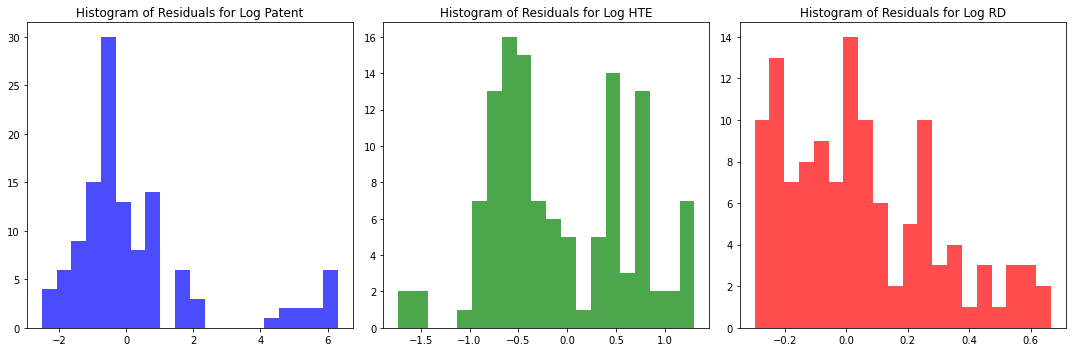

In [36]:
# Create plot and set axis values
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].hist(Tech['residual Log Patent'], bins=20, color='blue', alpha=0.7)
axs[0].set_title('Histogram of Residuals for Log Patent')

axs[1].hist(Tech['residual Log HTE'], bins=20, color='green', alpha=0.7)
axs[1].set_title('Histogram of Residuals for Log HTE')

axs[2].hist(Tech['residual Log RD'], bins=20, color='red', alpha=0.7)
axs[2].set_title('Histogram of Residuals for Log RD')

plt.tight_layout()
plt.show()

As we can see from the histograms above, our residual values for Log Patent are right skewed. This illustrates our previous assertion that the given residuals do not follow a normal distribution. As a result we will begin looking towards an alternative model to determine the impact of FDI on Patent applications. Prior to this, however, we will breifly conduct a Durbin-Watson test to determine whether autocorrelation is present since we have already visually conducted a visual check.

##### Durbin-Watson test

In [37]:
dw_patent = durbin_watson(Tech['residual Log Patent'])
dw_hte = durbin_watson(Tech['residual Log HTE'])
dw_rd = durbin_watson(Tech['residual Log RD'])

print(f"Durbin-Watson statistic for Log Patent residuals: {dw_patent:.3f}")
print(f"Durbin-Watson statistic for Log HTE residuals: {dw_hte:.3f}")
print(f"Durbin-Watson statistic for Log RD residuals: {dw_rd:.3f}")

Durbin-Watson statistic for Log Patent residuals: 2.361
Durbin-Watson statistic for Log HTE residuals: 2.359
Durbin-Watson statistic for Log RD residuals: 2.021


The Durbin-Watson test statistic ranges from 0 to 4, where a value around 2 indicates no autocorrelation, values less than 2 indicate positive autocorrelation, and values greater than 2 indicate negative autocorrelation.

- As we can see, for each variables residuals, little to no autocorrelation is present. This confirms our previous inference and we can rule our autocorrelation as a cause for concern.

##### Predicted Vs Actual Plots

Another way of identifying how good/accurate our model predicts the values of our dependent variables given FDI, is through plotting the predicted vs actual values. 

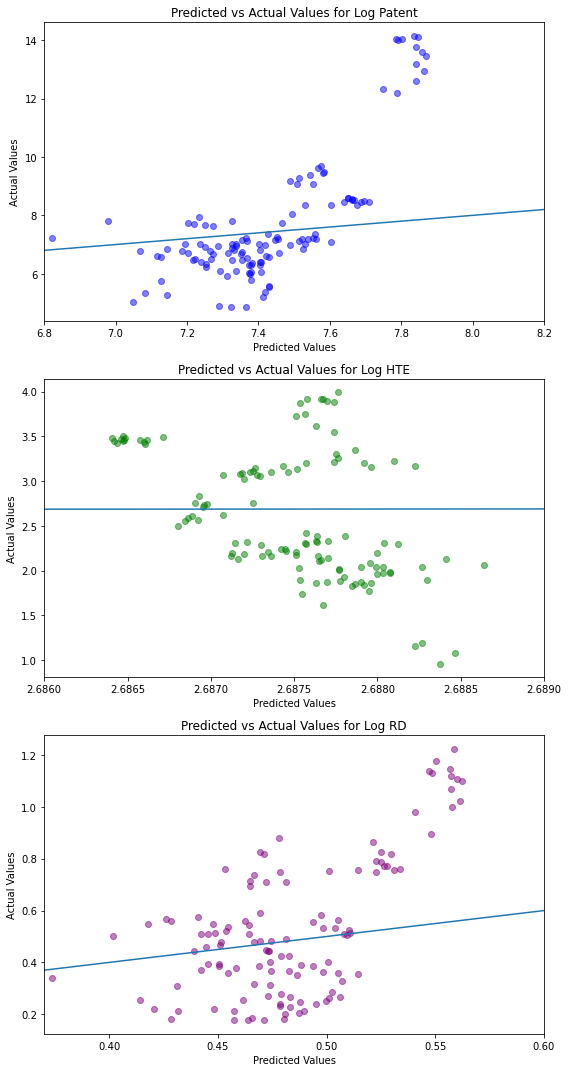

In [38]:
# Create figure
fig, axs = plt.subplots(3, 1, figsize=(8, 15))

# Log Patent
axs[0].scatter(Tech['fitted Log Patent'], Tech['Log Patent'], color='blue', alpha=0.5)
axs[0].plot([min(Tech['Log Patent']), max(Tech['Log Patent'])],
            [min(Tech['Log Patent']), max(Tech['Log Patent'])])
axs[0].set_title('Predicted vs Actual Values for Log Patent')
axs[0].set_xlabel('Predicted Values')
axs[0].set_ylabel('Actual Values')
axs[0].set_xlim(6.8, 8.2)

# Log HTE
axs[1].scatter(Tech['fitted Log HTE'], Tech['Log HTE'], color='green', alpha=0.5)
axs[1].plot([min(Tech['Log HTE']), max(Tech['Log HTE'])],
            [min(Tech['Log HTE']), max(Tech['Log HTE'])])
axs[1].set_title('Predicted vs Actual Values for Log HTE')
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Actual Values')
axs[1].set_xlim(2.686, 2.689)

# Log RD
axs[2].scatter(Tech['fitted Log RD'], Tech['Log RD'], color='purple', alpha=0.5)
axs[2].plot([min(Tech['Log RD']), max(Tech['Log RD'])],
            [min(Tech['Log RD']), max(Tech['Log RD'])])
axs[2].set_title('Predicted vs Actual Values for Log RD')
axs[2].set_xlabel('Predicted Values')
axs[2].set_ylabel('Actual Values')
axs[2].set_xlim(0.37, 0.6)

plt.tight_layout()
plt.show()


As we can see from the plots above, both the figure for Log Patent and Log RD exhibit a linear trend. The predicted Vs actual plot for Log HTE fails to illustrate a relationship. This is because from our Random-Effects model, there does not exist a statistically significant relationship between FDI and HTE.

For our Log RD predicted Vs actual plot however, we can see that quite a spurious relationship exists. Whilst a linear relationship between predicted values and actual values exits, this is not incredibly strong.

Additionally, we can see that whilst the relationship between the predicted values of Log Patent and the actual values tend to follow a somewhat strong linear relationship, strong outliers at high actual values violate this relationship, thus decreasing the magnitute of correlation.

In order to resolve this issue, we can remove outliers from our data, run the same models with outlier-free data and conduct the same robustness checks again to determine which model provides a better fit

##### Removing Outliers

In [39]:
# Define function to remove outliers using IQR method
def remove_outliers(data, column, k=1.5):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - k*iqr
    upper_bound = q3 + k*iqr
    return data[(data[column] > lower_bound) & (data[column] < upper_bound)]

# Remove outliers from Tech data for each variable
Tech_clean = Tech.copy()
Tech_clean = remove_outliers(Tech_clean, 'Log FDI')
Tech_clean = remove_outliers(Tech_clean, 'Log HTE')
Tech_clean = remove_outliers(Tech_clean, 'Log RD')
Tech_clean = remove_outliers(Tech_clean, 'Log Patent')

### Random Effects (removed outliers)

In [40]:
# Run Random-Effects Model
# Add a constant to the independent variable (Log FDI)
X = Tech_clean[['Log FDI']]
X = sm.add_constant(X)

# Run separate regressions for each dependent variable
dependent_vars = Tech_clean[['Log Patent', 'Log HTE', 'Log RD']]

for var in dependent_vars:
    y = Tech_clean[var]
    
    # Estimate the Random Effects model
    random_effects_model2 = RandomEffects(y, X)
    random_effects_results2 = random_effects_model2.fit()
    
    print(f"Results for {var} as the dependent variable:")
    print(random_effects_results2)
    print("\n")
      
    # Add the fitted values column to the Tech dataframe
    Tech_clean[f'fitted {var}'] = random_effects_results2.predict(X)

Results for Log Patent as the dependent variable:
                        RandomEffects Estimation Summary                        
Dep. Variable:             Log Patent   R-squared:                        0.2008
Estimator:              RandomEffects   R-squared (Between):              0.1582
No. Observations:                 107   R-squared (Within):               0.0394
Date:                Thu, Oct 19 2023   R-squared (Overall):              0.1448
Time:                        23:10:45   Log-likelihood                   -9.4642
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      26.387
Entities:                          14   P-value                           0.0000
Avg Obs:                       7.6429   Distribution:                   F(1,105)
Min Obs:                       0.0000                                           
Max Obs:                       13.000   F-statistic (robust

### Interpretation

##### Log Patent as the dependent variable:
The R-squared value has increased from 0.8030 to 0.2008, which indicates that the model without outliers explains a larger proportion of the variance in the dependent variable. However, the P-value for Log FDI has increased from 0.0106 to 0.0131, making it slightly less statistically significant. This suggests that the relationship between Log FDI and Log Patent is marginally weaker in the cleaned dataset.

##### Log HTE as the dependent variable:
The R-squared value has slightly decreased from 0.0951 to 0.0482. Additionally, the P-value for Log FDI has decreased from  0.9861 to 0.4803, making it more statistically significant. This implies that the relationship between Log FDI and Log HTE is stronger in the cleaned dataset.

##### Log RD as the dependent variable:
The R-squared value has decreased from 0.0091 to 0.0014, which means that the cleaned model explains less of the variance in the dependent variable. The P-value for Log FDI has also increased from 0.0304 to 0.4141, making it less statistically significant. This suggests that the relationship between Log FDI and Log RD is weaker in the cleaned dataset.

##### Overall: 
Removing outliers has led to varying changes in the R-squared values and the P-values of Log FDI for all three dependent variables. While the R-squared values for Log Patent has increased, the P-values have also increased, making the relationship between Log FDI and these dependent variables less statistically significant. For Log RD, the R-squared value has decreased and the P-value have increased, indicating a weaker relationship between Log FDI and Log RD in the cleaned dataset.

### Delayed Effects (removed outliers)

In [41]:
## Create Random-Effects model with lag
# Create a one-year lag of Log FDI
Tech_clean['Lag1 Log FDI'] = Tech_clean.groupby(level=0)['Log FDI'].shift(1)

# Drop rows with missing values due to lag creation
Tech_clean = Tech_clean.dropna()

# Create model variables
X = Tech_clean[['Log FDI', 'Lag1 Log FDI']]
X = sm.add_constant(X)

# Run separate regressions for each dependent variable
dependent_vars = ['Log Patent', 'Log HTE', 'Log RD']

for var in dependent_vars:
    y = Tech_clean[var]
    
    # Estimate the Random Effects model
    random_effects_model3 = RandomEffects(y, X)
    random_effects_results3 = random_effects_model3.fit()
    
    print(f"Results for delayed {var} as the dependent variable:")
    print(random_effects_results3)
    print("\n")
    
    Tech_clean[f'fitted2 {var}'] = random_effects_results3.predict(X)

Results for delayed Log Patent as the dependent variable:
                        RandomEffects Estimation Summary                        
Dep. Variable:             Log Patent   R-squared:                        0.2587
Estimator:              RandomEffects   R-squared (Between):              0.2019
No. Observations:                  95   R-squared (Within):               0.0326
Date:                Thu, Oct 19 2023   R-squared (Overall):              0.1835
Time:                        23:10:45   Log-likelihood                   -2.3885
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      16.050
Entities:                          14   P-value                           0.0000
Avg Obs:                       6.7857   Distribution:                    F(2,92)
Min Obs:                       0.0000                                           
Max Obs:                       12.000   F-statistic

### Interpretation

##### Log Patent as the dependent variable:
For Log Patent, the R-squared has increased from 0.1028 to 0.2587, indicating a better model fit. The coefficient for Log FDI has decreased slightly, but the p-value has increased, suggesting less significance. The coefficient for the lagged Log FDI is positive and significant (p-value = 0.0494), suggesting a delayed effect of FDI on patent activity.

##### Log HTE as the dependent variable:
For Log HTE, the R-squared remains relatively unchanged (0.0441 vs. 0.0738). The coefficient for Log FDI remains negative and not statistically significant, and the coefficient for the lagged Log FDI is very small and not statistically significant. This suggests no significant immediate or delayed effect of FDI on high-tech exports.

##### Log RD as the dependent variable:
For Log RD, the R-squared decreased slightly from 0.0334 to 0.0162, but the overall model fit remains very low. Both the coefficients for Log FDI and the lagged Log FDI are positive but not statistically significant. This implies that there is no significant immediate or delayed effect of FDI on R&D expenditures.

##### Overall: 
In summary, after removing outliers and incorporating a one-year lag, the delayed effects model shows some evidence of a delayed effect of FDI on patent activity. However, there is no significant immediate or delayed effect of FDI on high-tech exports or R&D expenditures.

### Robustness Checks

##### Scatter Plots

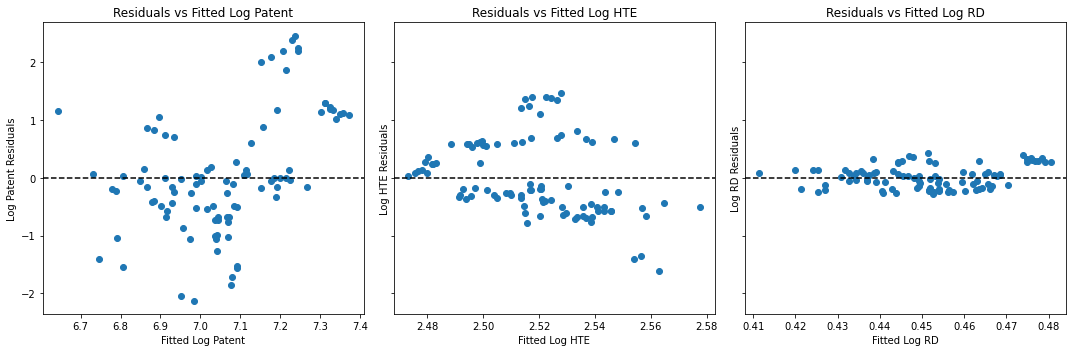

In [42]:
# Calculate residuals for each dependent variable
Tech_clean['residual Log Patent'] = Tech_clean['Log Patent'] - Tech_clean['fitted Log Patent']
Tech_clean['residual Log HTE'] = Tech_clean['Log HTE'] - Tech_clean['fitted Log HTE']
Tech_clean['residual Log RD'] = Tech_clean['Log RD'] - Tech_clean['fitted Log RD']

# Plot residuals against fitted values for each dependent variable
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

axes[0].scatter(Tech_clean['fitted Log Patent'], Tech_clean['residual Log Patent'])
axes[0].axhline(y=0, color='k', linestyle='--')
axes[0].set_xlabel('Fitted Log Patent')
axes[0].set_ylabel('Log Patent Residuals')
axes[0].set_title('Residuals vs Fitted Log Patent')

axes[1].scatter(Tech_clean['fitted Log HTE'], Tech_clean['residual Log HTE'])
axes[1].axhline(y=0, color='k', linestyle='--')
axes[1].set_xlabel('Fitted Log HTE')
axes[1].set_ylabel('Log HTE Residuals')
axes[1].set_title('Residuals vs Fitted Log HTE')

axes[2].scatter(Tech_clean['fitted Log RD'], Tech_clean['residual Log RD'])
axes[2].axhline(y=0, color='k', linestyle='--')
axes[2].set_xlabel('Fitted Log RD')
axes[2].set_ylabel('Log RD Residuals')
axes[2].set_title('Residuals vs Fitted Log RD')

plt.tight_layout()
plt.show()

There are 4 qualities which we want to identify when assessing our residual plots. These are as follows:

1. Random scatter: The residuals should be randomly scattered around the horizontal line at 0, with no clear pattern or trend. This indicates that the model is capturing the relationship between the variables reasonably well, and there is no systematic bias in the model's predictions.
- For our Log Patent and Log RD residual plots this tends to be the case. For our Log HTE residual plot, however, the residuals tend illustrate a degree of fanning, violating the 'random scatter' criterion. This indicates that there may be some inherent flaws with modelling the relationship between FDI and HTE with a Random-Effects Model.

2. Homoscedasticity: The spread of residuals should be roughly constant across the range of fitted values. If the spread of residuals increases or decreases as the fitted values change, it might indicate heteroscedasticity, which violates the assumption of constant variance in the errors. There should be no fanning.
- For all of our residual plots, the spread of residuals is relatively constant. However, yet again, for our Log HTE variable, the spread of residuals tends to widen at larger fitted values. This is a cause for concern as it may widen impact our confidence intervals, accuracy of standard errors and merit of our model overall.

3. No autocorrelation: As the data points are collected over time, there should be no visible correlation between adjacent residuals. Autocorrelation in the residuals might indicate that the model is not adequately capturing the underlying structure of the data.
- Yet again, whilst the residual plots for Patent and R&D tend to be absent of autocorrelation, our residual plot for Log HTE, tends to illustrate somewhat of an upwards trend. This may mean that an alternative model is better suited for this given variable.

4. Normally distributed: For a linear regression model, the residuals should approximately follow a normal distribution. In a residual plot, this would translate to a roughly equal number of points above and below the horizontal line at 0, with no extreme outliers.
- Lastly, both our R&D and Patent residual plot follow a consistent normal distribution. This is not the case for our Log Patent variable. The inherent skewedness can be illustrates below using a histogram. Such skewedness is yet again cause for concern since our model fits some, smaller datapoints, better than other, larger observations.

It seems that our Random-Effects model's residuals for Log HTE have a pattern, which indicates that the model might not be capturing some underlying trend or structure in the data. This can lead to biased or inefficient estimates. However, this is not as significant as our previous model not account for outliers. This is because we have determined that Log FDI has no significant impact of HTE, whereas Log FDI has a positive and statistically significant impact on Log Patent. This can be seen from the plots below.

##### Predicted Vs Actual Values

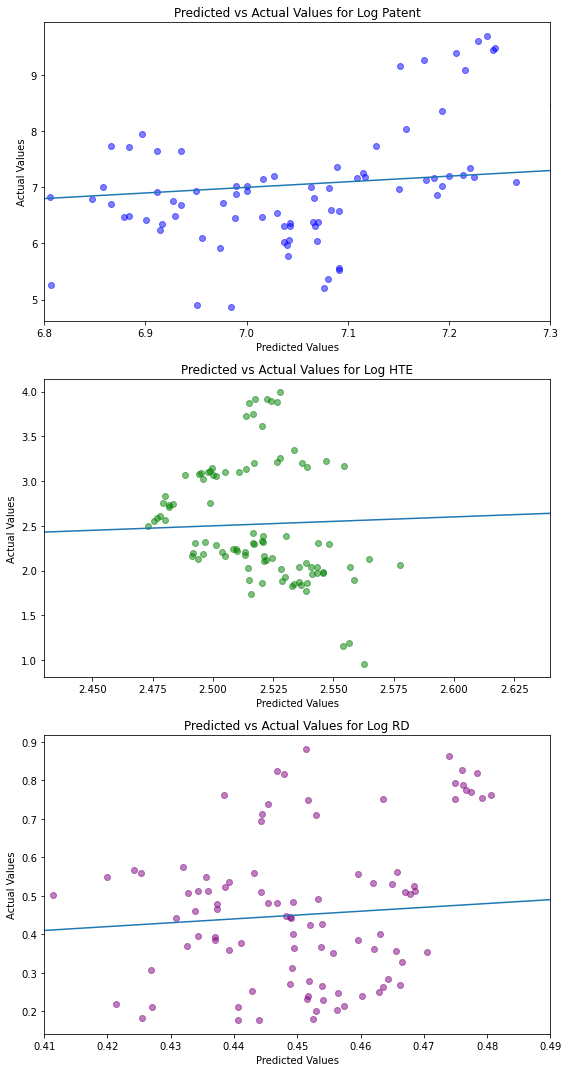

In [43]:
# Create figure
fig, axs = plt.subplots(3, 1, figsize=(8, 15))

# Log Patent
axs[0].scatter(Tech_clean['fitted Log Patent'], Tech_clean['Log Patent'], color='blue', alpha=0.5)
axs[0].plot([min(Tech_clean['Log Patent']), max(Tech_clean['Log Patent'])],
            [min(Tech_clean['Log Patent']), max(Tech_clean['Log Patent'])])
axs[0].set_title('Predicted vs Actual Values for Log Patent')
axs[0].set_xlabel('Predicted Values')
axs[0].set_ylabel('Actual Values')
axs[0].set_xlim(6.8, 7.3)

# Log HTE
axs[1].scatter(Tech_clean['fitted Log HTE'], Tech_clean['Log HTE'], color='green', alpha=0.5)
axs[1].plot([min(Tech_clean['Log HTE']), max(Tech_clean['Log HTE'])],
            [min(Tech_clean['Log HTE']), max(Tech_clean['Log HTE'])])
axs[1].set_title('Predicted vs Actual Values for Log HTE')
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Actual Values')
axs[1].set_xlim(2.43, 2.64)

# Log RD
axs[2].scatter(Tech_clean['fitted Log RD'], Tech_clean['Log RD'], color='purple', alpha=0.5)
axs[2].plot([min(Tech_clean['Log RD']), max(Tech_clean['Log RD'])],
            [min(Tech_clean['Log RD']), max(Tech_clean['Log RD'])])
axs[2].set_title('Predicted vs Actual Values for Log RD')
axs[2].set_xlabel('Predicted Values')
axs[2].set_ylabel('Actual Values')
axs[2].set_xlim(0.41, 0.49)

plt.tight_layout()
plt.show()


As we can see, the appropriate plots for both Log Patent and Log RD illustrate an upwards linear trend absent of fanning. This suggests that they provide an accurate an appopriate model for the impact of FDI on technological advancements. Due to the presence of fanning and an inconsistent trend between predicted and actual values, the same cannot be said for Log HTE.

### Per Capita Models

As we can see above, removing outliers can increase the accuracy of our models and therefore out estimations. However, many issues can arise from ommitting certain data. To avoid this issue, we can create models based on per capita values, this would accounts for differences in population size between countries, regions, or other units of analysis. Additionally, when comparing economic or social indicators across countries, using per capita data provides a more equitable basis for comparison, as it adjusts for population size. Lastly, if there is a strong relationship between population size and our variable of interest, using per capita data can help to account for this relationship and potentially lead to more accurate estimates, whilst also reducing multicolinearity. 

#### Random Effects Model

In [44]:
# Convert the DataFrame to a MultiIndex DataFrame with 'Country Name' and 'Year' as the index
Tech_per_capita = Tech_per_capita.set_index(['Country Name', 'Year'])

# Add a constant to the independent variable (Log FDI)
X = Tech_per_capita[['FDI per capita']]
X = sm.add_constant(X)

# Run separate regressions for each dependent variable
dependent_vars = ['Patent per capita', 'HTE per capita', 'RD per capita']

for var in dependent_vars:
    y = Tech_per_capita[var]
    
    # Estimate the Random Effects model
    random_effects_model_pc = RandomEffects(y, X)
    random_effects_results_pc = random_effects_model_pc.fit()
    
    print(f"Results for {var} as the dependent variable:")
    print(random_effects_results_pc)
    print("\n")
      
    # Add the fitted values column to the Tech dataframe
    Tech_per_capita[f'fitted {var}'] = random_effects_results_pc.predict(X)


Results for Patent per capita as the dependent variable:
                        RandomEffects Estimation Summary                        
Dep. Variable:      Patent per capita   R-squared:                        0.0252
Estimator:              RandomEffects   R-squared (Between):              0.0170
No. Observations:                 114   R-squared (Within):               0.0369
Date:                Thu, Oct 19 2023   R-squared (Overall):             -0.0142
Time:                        23:10:46   Log-likelihood                    1269.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2.8987
Entities:                          12   P-value                           0.0914
Avg Obs:                       9.5000   Distribution:                   F(1,112)
Min Obs:                       1.0000                                           
Max Obs:                       14.000   F-statistic 

### Interpretation

##### Log Patent as the dependent variable:
The FDI per capita has a positive coefficient of 1.085e-08 and is statistically significant with a p-value of 0.0458. This means that a 1-unit increase in FDI per capita leads to an increase of approximately 1.085e-08 units in Patent per capita, holding other factors constant. R-squared: 0.0252, indicating that about 2.52% of the variation in Patent per capita can be explained by the FDI per capita in the model. We can infer that additional foreign direct investment stimulates a degree of tech invoation, indicated by additional patent applications.

##### Log HTE as the dependent variable:
The FDI per capita has a negative coefficient of -8.382e-12, but it is not statistically significant with a p-value of 0.8579. This implies that the relationship between FDI per capita and HTE per capita is not statistically significant, and thus, we cannot make any meaningful conclusions about their relationship in this model. R-squared: 0.0304, which means that only 3.04% of the variation in HTE per capita can be explained by the FDI per capita in the model.

##### RD per capita as the dependent variable:
The FDI per capita has a positive coefficient of 4.359e-12, but it is not statistically significant with a p-value of 0.1427. This means that we cannot conclude any statistically significant relationship between FDI per capita and RD per capita based on this model. R-squared: -0.0009, which indicates that the model does not fit the data well. The negative R-squared suggests that the model performs worse than a horizontal line through the mean of the dependent variable.

##### Overall:
In summary, the models suggest that FDI per capita has a statistically significant positive effect on Patent per capita, but there is no statistically significant relationship between FDI per capita and HTE per capita or RD per capita. The R-squared values for all three models are quite low, indicating that these models do not explain much of the variation in the dependent variables. Overall, there tends to be significant evidence that additional FDI tends to lead to additional patent applications.

### Robustness Check

As with the previous models, we can conduct a breif robustness check to determine the accuracy of our models above in order to extract reliable inference.

#### Residual plots

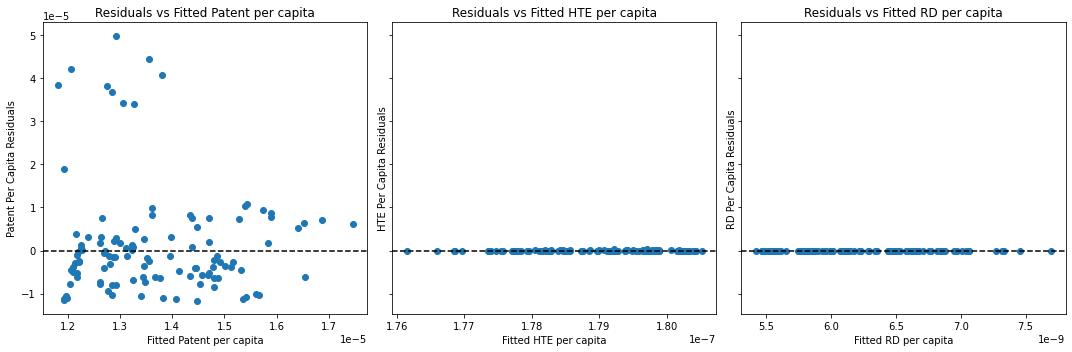

In [45]:
# Calculate residuals for each dependent variable
Tech_per_capita['residual Patent per capita'] = Tech_per_capita['Patent per capita'] - Tech_per_capita['fitted Patent per capita']
Tech_per_capita['residual HTE per capita'] = Tech_per_capita['HTE per capita'] - Tech_per_capita['fitted HTE per capita']
Tech_per_capita['residual RD per capita'] = Tech_per_capita['RD per capita'] - Tech_per_capita['fitted RD per capita']

# Plot residuals against fitted values for each dependent variable
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

axes[0].scatter(Tech_per_capita['fitted Patent per capita'], Tech_per_capita['residual Patent per capita'])
axes[0].axhline(y=0, color='k', linestyle='--')
axes[0].set_xlabel('Fitted Patent per capita')
axes[0].set_ylabel('Patent Per Capita Residuals')
axes[0].set_title('Residuals vs Fitted Patent per capita')

axes[1].scatter(Tech_per_capita['fitted HTE per capita'], Tech_per_capita['residual HTE per capita'])
axes[1].axhline(y=0, color='k', linestyle='--')
axes[1].set_xlabel('Fitted HTE per capita')
axes[1].set_ylabel('HTE Per Capita Residuals')
axes[1].set_title('Residuals vs Fitted HTE per capita')

axes[2].scatter(Tech_per_capita['fitted RD per capita'], Tech_per_capita['residual RD per capita'])
axes[2].axhline(y=0, color='k', linestyle='--')
axes[2].set_xlabel('Fitted RD per capita')
axes[2].set_ylabel('RD Per Capita Residuals')
axes[2].set_title('Residuals vs Fitted RD per capita')

plt.tight_layout()
plt.show()

As we can see from the residual plots above, there is no clear violation of any previous mentioned condition. Overall, there is no evidence of skewedness, fanning or heteroskedasticity. Ultimately, although our robustness check is limited, our model seems fairly accurate.

## Findings (conclusion)

We begun this project with the initial hypotheses:

- The hypothesis, prior to analysing any data, is that foreign direct investment positively influences technological advancements in emerging economies. An increase in FDI will increase R&D, HTE and Patent applications, all else being held constant.

Null Hypothesis H0: Foreign direct investment has no impact on technological advancement in emerging economies.

Alternative Hypothesis HA: Foreign direct investment has a statistically significant impact on technological advancement in emerging economies.

##### Organising Data

In order to test these hypothesis, we first had to collect and organise our data. Prior to collecting our data, we had to determine which variables would be sufficient and accurate indicators of technological advancements. These indicators were High Tech Exports, Research and Development, and Patent Applications. Our whole projected hinges upon these assumptions - if these indicators are not valid, it would be impossible to determine the impact of foreign direct investment on technological advancements. Additionally, as our project titled fixated on 'Emerging Economies', we also had to determine which countries met such a 'Emerging' condition. We subsequently collected our data from the World Bank. Following this, it was crucial to create a singular dataset, including FDI and all three indicators for our 'Emerging Economies', in order to conduct analysis. 

##### Explanatory Data Analysis

Once we had our data organised and formatted, we were able to conduct explanatory data analysis. This was mainly in the form of visualising our data. It was crucial to initially visualise our data to simply ensure that any conclusions we make, follow both logic and the visual relationships we can infer. Initially, it was evident that a handful of countries received the majority share of FDI. In order to negate this issue, we illustrated FDI at a per capita level. From this plot, we were able to infer that, whilst a few countries received a large share of FDI, it was relatively evenly distributed.

As part of our explanatory analysis, we were tasked with identifying linearity within the data to enable us to produce statistical models to further our analysis. From this, we concluded that both our log transformed data and our per capita data (excluding outliers) exhibited such a trend. This enabled us to move onto modelling our data. 

##### Statistical Data Analysis

After previously idenfiying two linear trends in our data, we were able to begin statistical analysis. The premise of our analysis fixated on choosing the correct model. As each model type help merit in its own regard, it was best to produce all three models and compare them. Our Fixed-Effects model allowed us to eliminates the individual-specific effect, such as population differences, whilst controlling for all time-invariant unobserved heterogeneity. A Random-Effects model, however, was perhaps best suited. As it was likely that our dependent variables had unique, unobserved characteristics, instead of absorbing these effects into the constant, our Random-Effects model accounted for these not assuming that the effect of each entity is constant across time. Lastly, we included a Delayed-Effects model since it was likley that changes in our X-variable did not impact our Y-variables until they were fully realised in the next period. In other words, changes in FDI lead to increases or decreases in our technological advancement indicators not in the same period but the next. Overall, each model held merit in its own regard.

As we now obtained results from a variety of different models, it was cruical to determine which provided the best model for our data. From this, we conducted robustness checks.

##### Robustness Checks

In order to determine which model best served our data, we wanted to first check if any model violated any of the conditions neccessary for an accurate model. We could visualise this from residual plots. From the first Random-Effects model, we identified that our residuals for our 'Log HTE' and Log 'RD'variables met these said conditions, however, when plotting the residuals for 'Log Patent', we concluded that our initial Random-Effects model was not appropriate. 

From our explanatory data analysis, we concluded that large outliers skewed our data. In order to correct for this, and better model our 'Log Patent' variable, we produced a Random-Effects model absent of outliers. From this model, however, our residual plots illustrated that our 'Log HTE' variable had fanning residuals. Unlike 'Log Patent', our previous models illustrates that FDI has no statistically significant impact on high tech exports, as a results, this issue was not incredibly problematic. However, in order to produce the most accurate and approrpiate model, we believed that it might be best to produce a Random-Effects model using per-capita values. From our robstness checks, this model looked perhaps the most accurate.

##### Overall Findings

As previously discussed, in order to best determine the impact of foreign direct investment on technological advancements, we produced multiple models in order to increase the accuracy of our estimates. 

1) Perhaps our most convincing finding is between the effect of foreign direct investment on Patent activity. All three of our Random-Effects models (including outliers, excluding outliers, and per-capita) indicate that foreign direct investment has a statistically significant impact on patent applications. From this we conclude that additional investment in an emerging economy increases the level of entrepreneurship, but that is not to say that technological advancements come of it. 


2) Additionally, from all of our models (Fixed-Effects, Random-Effects, Delayed-Effects) we can infer that Foreign Direct Investment has no statistically significant impact on High Tech Exports. This is perhaps suprising as we previously found that increases in foreign economic injections lead to an increase in patent applications. From this we can infer that individuals would produce high tech products and export them to foreign markets. Perhaps, however, the products in which these individuals are producing may not be considered 'High Tech' or may simply be sold exclusively in the domestic market. 


3) Lastly, from our Random-Effects and Delayed-Effects model (with outliers), we find that the impact of foreign direct investment on Research and Development is positive and marginally significant. The same cannot be said for all of our models excluding outliers and using per-capita values. From this we can infer two things. Firstly, we can perhaps pin the relationship between FDI and R&D on those countries which skew our data, namely China and Malaysia. It is likely that due to the magnitude of these economies, research and development is at the forefront of technological advancements. As a result, we could conclude that foreign direct investment stimulates reasearch and development in countries with a larger share of foreign injections. Alternatively, we could infer that there is a lag in the relationship between FDI and R&D. Increases in foreign direct investment incentivise research and development in the next period. 

Whilst these findings are interesting, the main premise fixates on the aim of implementing effective and achievable policies. 

##### Advise to Policymakers

As we can see from our findings above, the relationship between foreign direct investment and patent applications is most prominent. However, this is not utilised to its greatest potential. Whilst many individuals patent an idea, this tends not to translate to high tech exports. Other constraints within the economy can hamper their ability to complete and produce the good/service. As a result, policymakers should perhaps look towards bridging the gap between 'ideas' and 'concepts', and the actual production and exportation of goods. Such a policy could be in the form of subsidies for 'High Tech Ideas'. Exporting such a product would expose a countries domestic market to the international market, in turn boosting their economy.

Following such a policy, in order to follow suit of larger, mega economies such as China and even Malaysia, policymakers should look towards incentivising research and development. In doing so, however, it will be important for the policymaker to keep in mind that the effect of foreign investment on research and development may not be realised until the following period. In other words, they should avoid over subsidising research and development by underestimating the impact of foreign investment in the current period. 

##### Closing Notes

Overall, it is incredibly important to note that our finding throughout this project hinge upon a few assumptions:

Firstly, we make an assumption as to what constitutes an 'indicator of technological advancements'. Whilst the ones we have included hold merit, it is likely that we have ommitted may indicators which would have conveyed a larger impact of foreign direct investment. 

Additionally, we have created an assumption of what constituites an 'Emerging Economy'. Whilst the countries we have used seem accurate, it is important to note the fluctuation of economies and the impact of this on the merit of our project. Whilst we include 'Mexico', for instance, as an emerging economy, in years to come this may not be the case. 

Lastly, whilst we generalise advise to policymakers, it is important to note that what may be effective for one country, is not necessary ideal for another. In order to provide the most effective policy advise, it is pertinent to conduct statistical analysis using data from the relevant country. 

Ultimately, we can conclude that Foreign Direct Investment does have an influence on technological advancements in emerging economies.